In [1]:
import cv2

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 85s 0us/step


In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

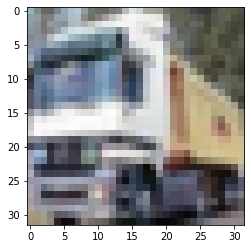

In [4]:
plt.imshow(x_train[1])
plt.show()

1. Konwersja na greyscale
2. Normalizacja + float
3. Tworzenie sieci

In [5]:
img_test = cv2.cvtColor(x_train[1], cv2.COLOR_BGR2GRAY)

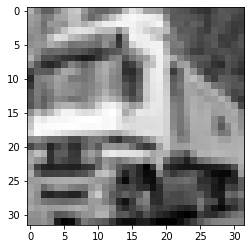

In [6]:
plt.imshow(img_test, cmap= 'gray')

In [7]:
img_test.shape

(32, 32)

In [8]:
x_train_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in x_train]

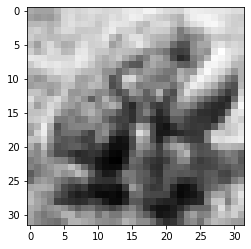

In [9]:
plt.imshow(x_train_gray[154], cmap = 'gray')

In [10]:
x_train_gray = np.array(x_train_gray)

In [11]:
x_train_gray =  x_train_gray/255
x_train = x_train/255

In [12]:
x_train_gray = x_train_gray.astype('float32')
x_train = x_train.astype('float32')

In [13]:
x_train_gray = x_train_gray.reshape(-1,32,32,1)

In [14]:
latent_dim = 256
filters = [32, 64, 128]

In [15]:
x_train.shape

(50000, 32, 32, 3)

In [24]:
inputs = Input(shape = x_train_gray[0].shape)
x = inputs
for f in filters:
    x = Conv2D(filters=f, kernel_size=3,
               strides=2, activation='relu',
              padding='same')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output = Dense(latent_dim, activation='linear')(x)

encoder = Model(inputs, output, name = 'encoder')

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               6579

In [25]:
# create decoder
latent = Input(shape=(latent_dim,))
api = Dense(2048)(latent)
api = Reshape([4, 4,128])(api)
for f in filters[::-1]:
    api = Conv2DTranspose(filters=f,
                         kernel_size=3,
                         padding='same',
                         strides=2,
                         activation='relu')(api)
    
output = Conv2DTranspose(filters=3,
                        kernel_size=3,
                        padding='same',
                        strides=1,
                        activation='sigmoid')(api)

decoder = Model(latent, output)
decoder.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              526336    
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 8, 8, 128)         147584    
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 16, 16, 64)        73792     
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 32, 32, 3)         867 

In [31]:
# create autoencoder 
autoencoder = Model(inputs, decoder(encoder(inputs)))
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 256)               683008    
_________________________________________________________________
model_2 (Functional)         (None, 32, 32, 3)         767043    
Total params: 1,450,051
Trainable params: 1,450,051
Non-trainable params: 0
_________________________________________________________________


In [32]:
autoencoder.compile(optimizer='adam', loss='mse')

In [33]:
autoencoder.fit(x_train_gray,
               x_train,
               batch_size=64,
               epochs=1,               
               )

782/782 [==============================] - 221s 279ms/step - loss: 0.0287


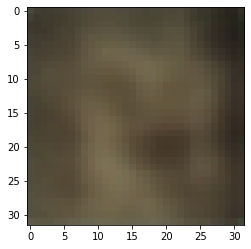

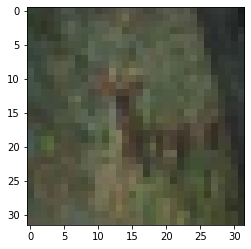

In [39]:
sample = 10
pred_sample = autoencoder.predict(x_train_gray[sample].reshape(1,32,32,1))
plt.imshow(pred_sample.reshape(32,32,3))
plt.show()
plt.imshow(x_train[sample])
plt.show()
